# imports

In [1]:
import os

base_dir = '/home/azam1/workspace/MultiModal/src/'
os.chdir(base_dir)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [127]:
class VAE(nn.Module):
    
    def __init__(self, encoder1_1, encoder1_2, encoder2, decoder1, decoder2, encoder_dims, latent_dims, device):
        super().__init__()
        self.encoder1_1 = encoder1_1
        self.encoder1_2 = encoder1_2
        self.encoder2 = encoder2
        self.decoder1 = decoder1
        self.decoder2 = decoder2
        self.latent_dims = latent_dims
        self.encoder_dims = encoder_dims
        self.mu1_1 = nn.Linear(encoder_dims, latent_dims)
        self.mu1_2 = nn.Linear(encoder_dims, latent_dims)
        self.mu2 = nn.Linear(encoder_dims, latent_dims)
        self.sigma1_1 = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.sigma1_2 = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.sigma2 = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.apply(self.init_parameters)
        self.device = device
    
    def init_parameters(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def encode(self, x1, x2):
        mu1_1, sigma1_1, mu1_2, sigma1_2, mu2, sigma2 = None, None, None, None, None, None
        if type(x1) == torch.Tensor:
            x1_1 = self.encoder1_1(x1)
            mu1_1 = self.mu1_1(x1_1)
            sigma1_1 = self.sigma1_1(x1_1)
            x1_2 = self.encoder1_2(x1)
            mu1_2 = self.mu1_2(x1_2)
            sigma1_2 = self.sigma1_2(x1_2)
        if type(x2) == torch.Tensor:
            x2 = self.encoder2(x2)
            mu2 = self.mu2(x2)
            sigma2 = self.sigma2(x2)
        return mu1_1, sigma1_1, mu1_2, sigma1_2, mu2, sigma2
    
    def decode(self, z1_1, z1_2, z2):
        x1, x2 = None, None
        if type(z1_1) == torch.Tensor:
            x1 = self.decoder1(torch.cat((z1_1, z1_2), dim=1))
        if type(z2) == torch.Tensor:
            x2 = self.decoder2(z2)
        return x1, x2

    def forward(self, x1, x2, average=True):
        z_params = self.encode(x1, x2)
        z1_1_, z1_2_, z2_ = self.reparameterize(z_params)
        x1_, x2_ = self.decode(z1_1_, z1_2_, z2_)
        
        kld1, kld2, wl, wd = self.kld_loss(z_params)
        loss1, loss2 = self.reconstruction_loss(x1_, x1, x2_, x2, average=average)
        
        return x1_, x2_, kld1, kld2, loss1, loss2, wl, wd
    
    def reparameterize(self, z_params):
        mu1_1, sigma1_1, mu1_2, sigma1_2, mu2, sigma2 = z_params
        z1_1, z1_2, z2 = None, None, None
        if type(mu1_1) == torch.Tensor:
            n_batch = mu1_1.size(0)
            q = distrib.Normal(torch.zeros(mu1_1.shape[1]), torch.ones(sigma1_1.shape[1]))
            z1_1 = (sigma1_1 * q.sample((n_batch, )).to(self.device)) + mu1_1
            n_batch = mu1_2.size(0)
            q = distrib.Normal(torch.zeros(mu1_2.shape[1]), torch.ones(sigma1_2.shape[1]))
            z1_2 = (sigma1_2 * q.sample((n_batch, )).to(self.device)) + mu1_2
        if type(mu2) == torch.Tensor:
            n_batch = mu2.size(0)
            q = distrib.Normal(torch.zeros(mu2.shape[1]), torch.ones(sigma2.shape[1]))
            z2 = (sigma2 * q.sample((n_batch, )).to(self.device)) + mu2
        return z1_1, z1_2, z2

    def kld_loss(self, z_params):
        mu1_1, sigma1_1, mu1_2, sigma1_2, mu2, sigma2 = z_params
        kld1, kld2 = -1, -1 # -1 denotes corresponding mode is absent
        wass_loss, wass_diff = -1, -1
        if type(mu1_1) == torch.Tensor:
            n_batch = mu1_1.size(0)
            kld1_1 = -0.5 * torch.sum(1 + sigma1_1 - mu1_1.pow(2) - sigma1_1.exp()) / n_batch
            n_batch = mu1_2.size(0)
            kld1_2 = -0.5 * torch.sum(1 + sigma1_2 - mu1_2.pow(2) - sigma1_2.exp()) / n_batch
        if type(mu2) == torch.Tensor:
            n_batch = mu2.size(0)
            kld2 = -0.5 * torch.sum(1 + sigma2 - mu2.pow(2) - sigma2.exp()) / n_batch
        if type(mu1_2) == torch.Tensor and type(mu2) == torch.Tensor:
            wass_loss = torch.norm(mu1_2 - mu2) + torch.sum(
                sigma1_2 + sigma2 - 2*(sigma1_2**(1/2) * sigma2 * sigma1_2*(1/2))**(1/2)
            )
#             wass_diff = torch.norm(mu1_1 - mu1_2) + torch.sum(
#                 sigma1_1 + sigma1_2 - 2*(sigma1_1**(1/2) * sigma1_2 * sigma1_1*(1/2))**(1/2)
#             )
        return kld1_1+kld1_2, kld2, wass_loss, wass_diff

    def reconstruction_loss(self, x1_, x1, x2_, x2, average=True):
        loss1, loss2 = None, None
        if type(x1_) == torch.Tensor:
            loss1 = F.binary_cross_entropy(x1_, x1, reduction='none').sum(dim = 0)
        if type(x2_) == torch.Tensor:
            loss2 = F.binary_cross_entropy(x2_, x2, reduction='none').sum(dim = 0)
        if (average):
            if type(loss1) == torch.Tensor:
                loss1 = loss1.sum() / x1.size(0)
            if type(loss2) == torch.Tensor:
                loss2 = loss2.sum() / x2.size(0)
        return loss1, loss2

In [128]:
class Flatten(nn.Module):
    def __init__(self, start_dim=1, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim
        
    def forward(self, tensor):
        return tensor.flatten(self.start_dim, self.end_dim)
    
class UnFlatten(nn.Module):
    def __init__(self, dim, unflattened_size):
        super(UnFlatten, self).__init__()
        self.dim = dim
        self.unflattened_size = unflattened_size
        
    def forward(self, tensor):
        dim0 = tensor.size(0)
        return tensor.reshape(dim0, *self.unflattened_size)

def construct_encoder_decoder(nin, n_channels, n_latent, n_hidden):
    
    encoder1_1 = nn.Sequential(
                nn.Conv2d(n_channels, 8, 3, stride=2, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 16, 3, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=0),
                nn.ReLU(True),
                Flatten(start_dim=1),
                nn.Linear(3 * 3 * 32, 128),
                nn.ReLU(True),
                nn.Linear(128, n_hidden)
            )
    
    encoder1_2 = nn.Sequential(
                nn.Conv2d(n_channels, 8, 3, stride=2, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 16, 3, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=0),
                nn.ReLU(True),
                Flatten(start_dim=1),
                nn.Linear(3 * 3 * 32, 128),
                nn.ReLU(True),
                nn.Linear(128, n_hidden)
            )
    
    encoder2 = nn.Sequential(
                nn.Linear(nin, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden))

    decoder1 = nn.Sequential(
            nn.Linear(2*n_latent, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            UnFlatten(dim=10, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    decoder2 = nn.Sequential(
                nn.Linear(n_latent, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, nin),
                nn.Sigmoid())
    
    return encoder1_1, encoder1_2, encoder2, decoder1, decoder2

In [129]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from data.loader import get_loader

batch_size = 64
shuffle = True
train_loader = get_loader('mnist', batch_size, train=True)
test_loader = get_loader('mnist', batch_size, train=False)

train_dataset = train_loader.dataset
_, _, idx_unsup, idx_sup = train_test_split(
    list(range(len(train_dataset))),
    list(range(len(train_dataset))),
    test_size = 0.1
)

unsup_train_dataset = Subset(train_dataset, idx_unsup)
sup_train_dataset = Subset(train_dataset, idx_sup)

unsup_train_loader = torch.utils.data.DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=shuffle)
sup_train_loader = torch.utils.data.DataLoader(sup_train_dataset, batch_size=batch_size, shuffle=shuffle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


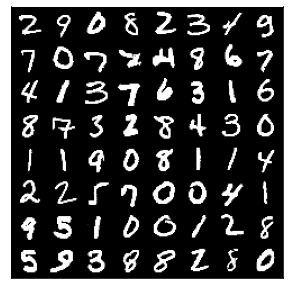

In [130]:
%matplotlib inline
from torchvision.utils import make_grid


# Select a random set of fixed data
fixed_batch, fixed_targets = next(iter(test_loader))
grid = make_grid(fixed_batch)
plt.figure(figsize=(5, 5))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.xticks([])
plt.yticks([])
plt.show()

In [131]:
n_hidden = 128
n_latent = 64
n_classes = 10
nin =  n_classes
n_channel = fixed_batch.size(1)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device for training: {device}')

encoder1_1, encoder1_2, encoder2, decoder1, decoder2 = construct_encoder_decoder(nin, n_channel, n_latent, n_hidden)
model = VAE(encoder1_1, encoder1_2, encoder2, decoder1, decoder2, n_hidden, n_latent, device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)

device for training: cuda


  0%|          | 0/844 [00:00<?, ?it/s]

<Figure size 360x360 with 0 Axes>

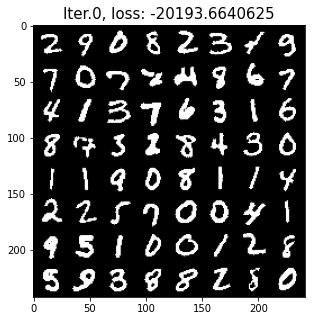

  0%|          | 0/844 [00:00<?, ?it/s]

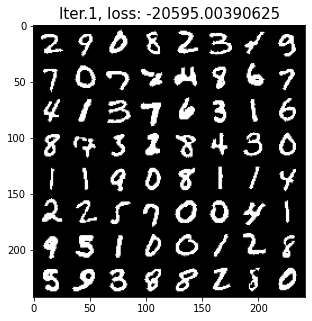

  0%|          | 0/844 [00:00<?, ?it/s]

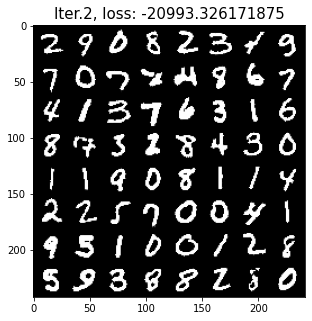

  0%|          | 0/844 [00:00<?, ?it/s]

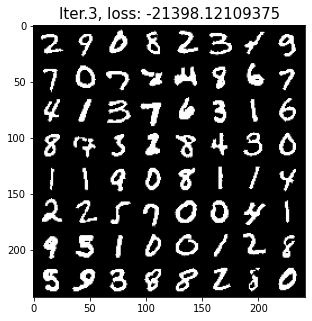

  0%|          | 0/844 [00:00<?, ?it/s]

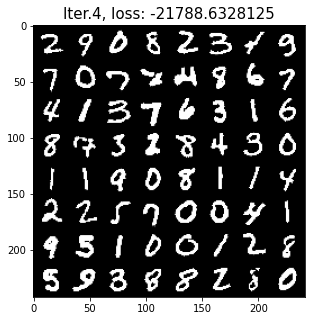

  0%|          | 0/844 [00:00<?, ?it/s]

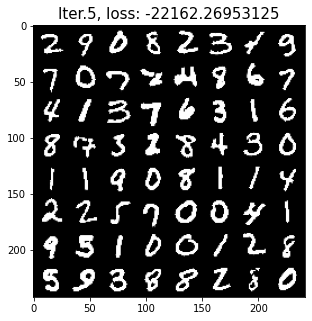

  0%|          | 0/844 [00:00<?, ?it/s]

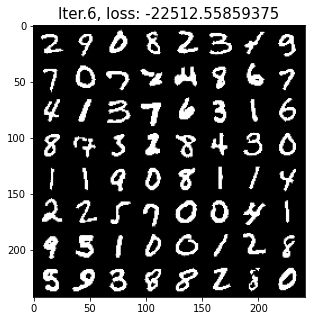

  0%|          | 0/844 [00:00<?, ?it/s]

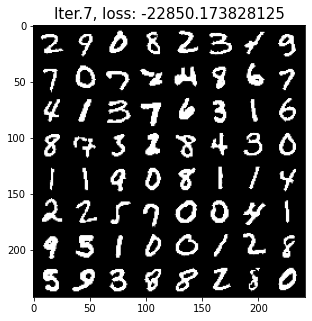

  0%|          | 0/844 [00:00<?, ?it/s]

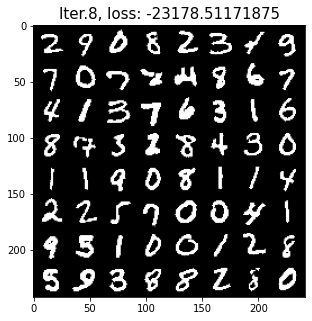

  0%|          | 0/844 [00:00<?, ?it/s]

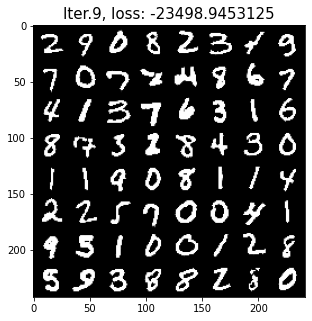

  0%|          | 0/844 [00:00<?, ?it/s]

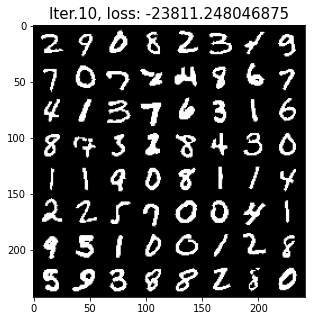

  0%|          | 0/844 [00:00<?, ?it/s]

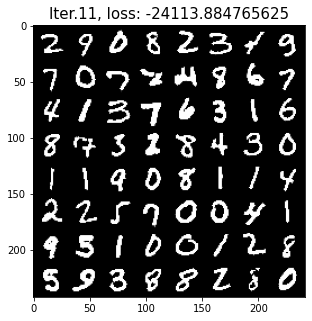

  0%|          | 0/844 [00:00<?, ?it/s]

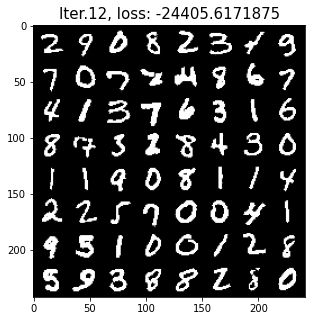

  0%|          | 0/844 [00:00<?, ?it/s]

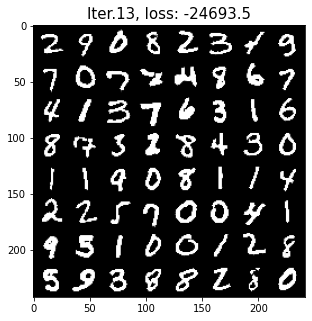

  0%|          | 0/844 [00:00<?, ?it/s]

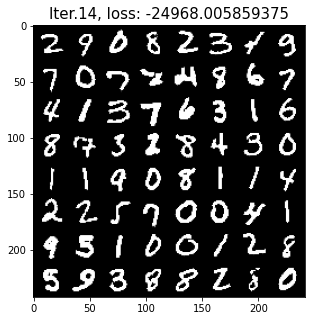

  0%|          | 0/844 [00:00<?, ?it/s]

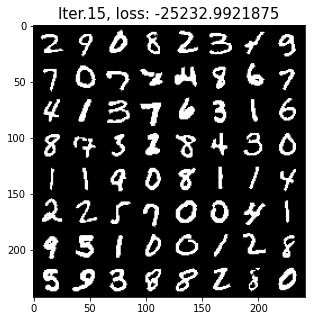

  0%|          | 0/844 [00:00<?, ?it/s]

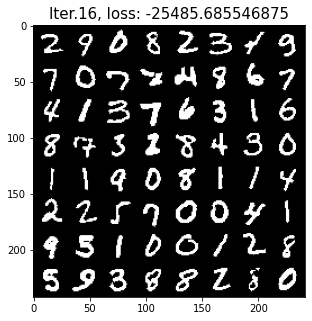

  0%|          | 0/844 [00:00<?, ?it/s]

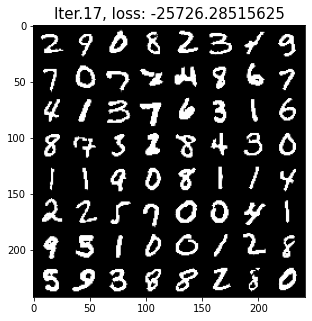

  0%|          | 0/844 [00:00<?, ?it/s]

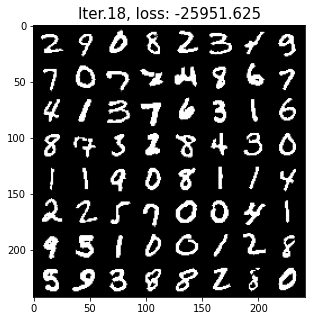

  0%|          | 0/844 [00:00<?, ?it/s]

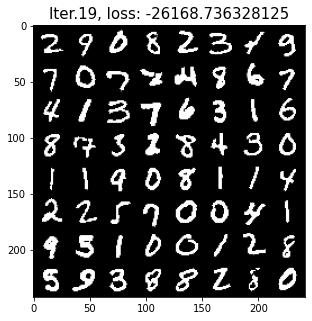

  0%|          | 0/844 [00:00<?, ?it/s]

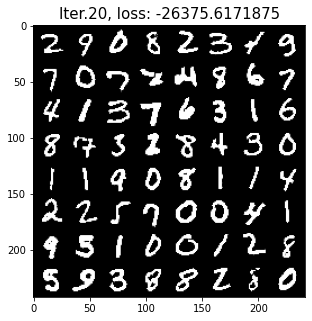

  0%|          | 0/844 [00:00<?, ?it/s]

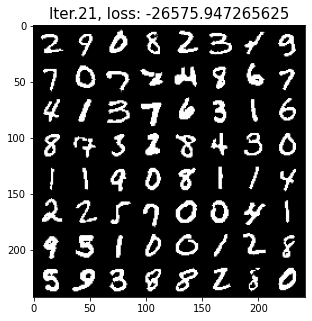

  0%|          | 0/844 [00:00<?, ?it/s]

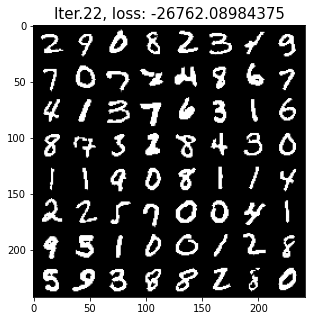

  0%|          | 0/844 [00:00<?, ?it/s]

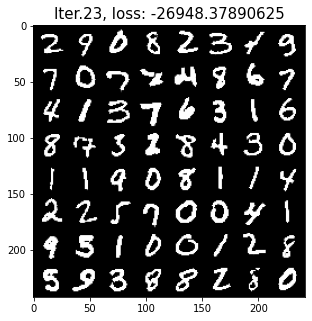

  0%|          | 0/844 [00:00<?, ?it/s]

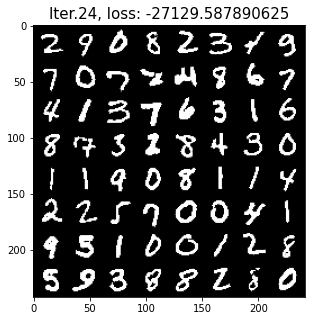

  0%|          | 0/844 [00:00<?, ?it/s]

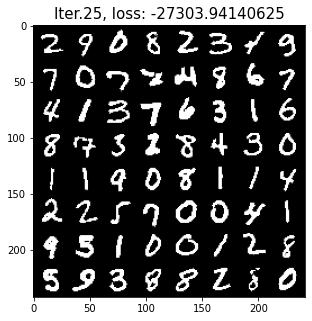

  0%|          | 0/844 [00:00<?, ?it/s]

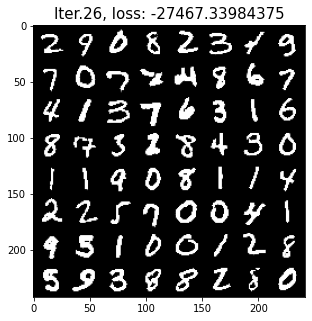

  0%|          | 0/844 [00:00<?, ?it/s]

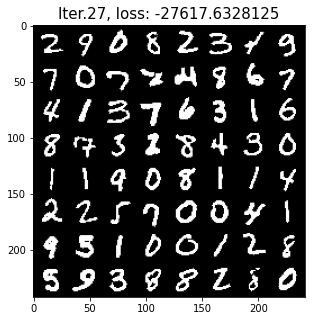

  0%|          | 0/844 [00:00<?, ?it/s]

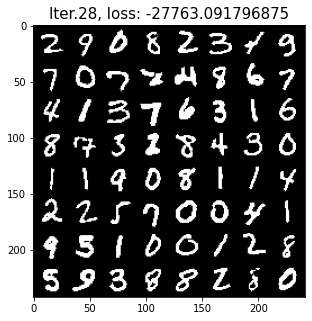

  0%|          | 0/844 [00:00<?, ?it/s]

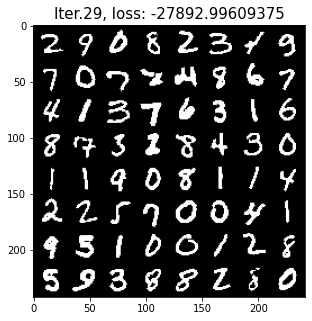

  0%|          | 0/844 [00:00<?, ?it/s]

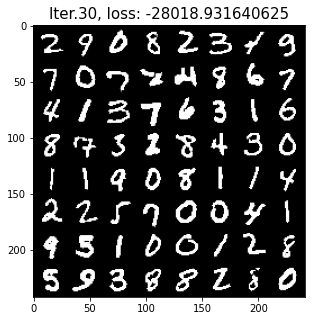

  0%|          | 0/844 [00:00<?, ?it/s]

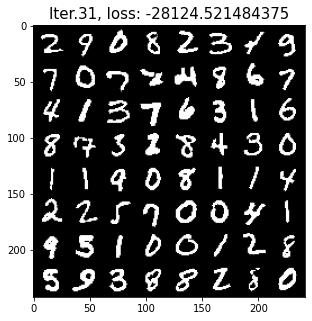

  0%|          | 0/844 [00:00<?, ?it/s]

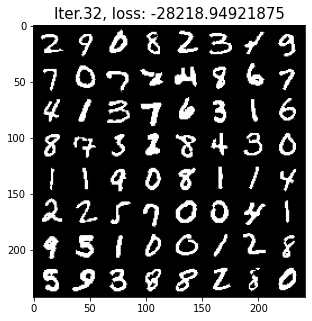

  0%|          | 0/844 [00:00<?, ?it/s]

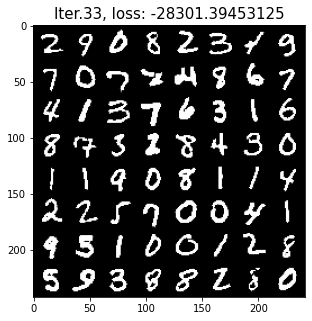

  0%|          | 0/844 [00:00<?, ?it/s]

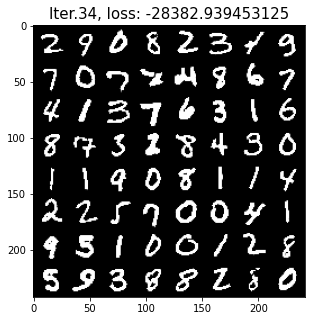

  0%|          | 0/844 [00:00<?, ?it/s]

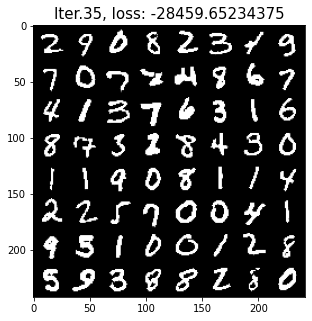

  0%|          | 0/844 [00:00<?, ?it/s]

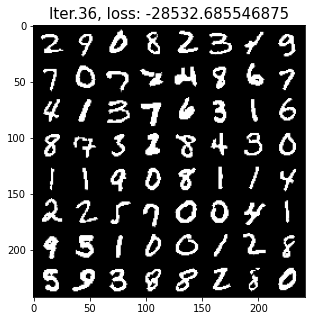

  0%|          | 0/844 [00:00<?, ?it/s]

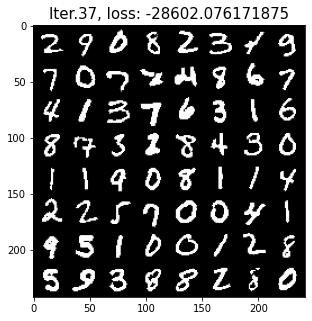

  0%|          | 0/844 [00:00<?, ?it/s]

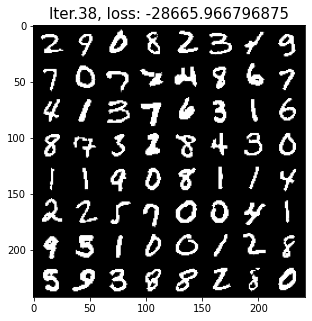

  0%|          | 0/844 [00:00<?, ?it/s]

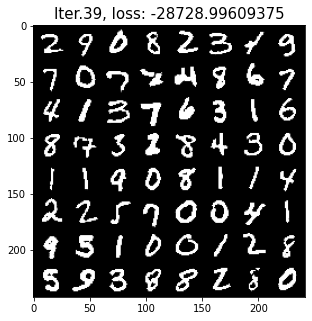

  0%|          | 0/844 [00:00<?, ?it/s]

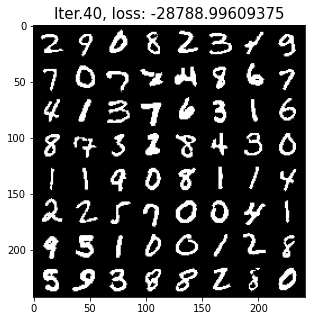

  0%|          | 0/844 [00:00<?, ?it/s]

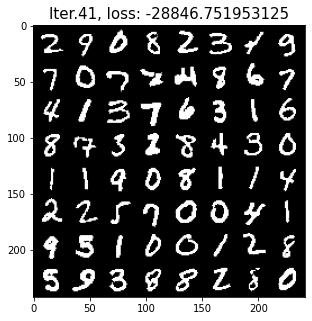

  0%|          | 0/844 [00:00<?, ?it/s]

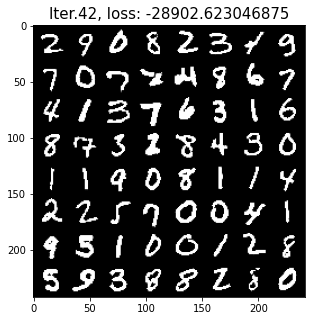

  0%|          | 0/844 [00:00<?, ?it/s]

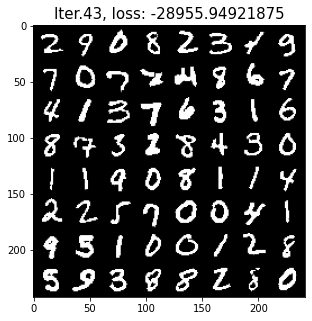

  0%|          | 0/844 [00:00<?, ?it/s]

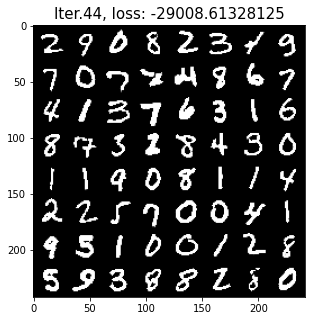

  0%|          | 0/844 [00:00<?, ?it/s]

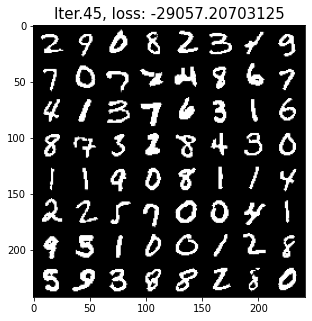

  0%|          | 0/844 [00:00<?, ?it/s]

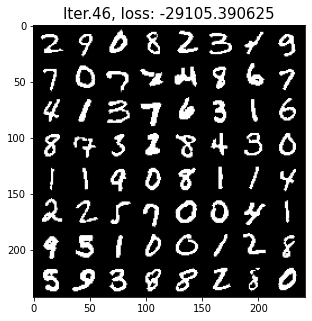

  0%|          | 0/844 [00:00<?, ?it/s]

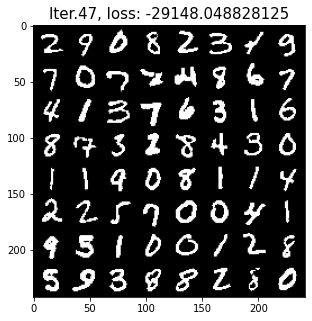

  0%|          | 0/844 [00:00<?, ?it/s]

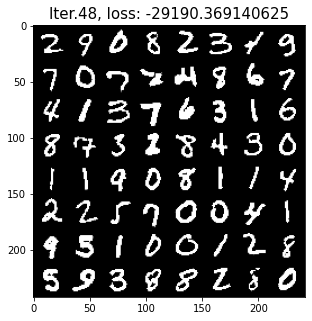

  0%|          | 0/844 [00:00<?, ?it/s]

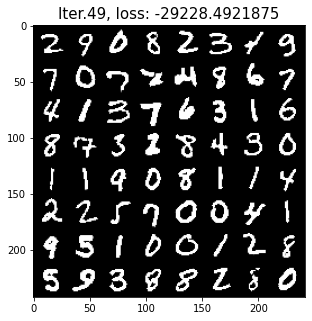

In [138]:
def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

def train_vae(model, 
              optimizer, scheduler, train_loader, 
              fixed_batch, epochs, plot_it=1):
    losses = torch.zeros(epochs, 8)
    beta = 0
    alpha = 1
    ims = []
    fig = plt.figure(figsize=(5, 5))

    for it in range(epochs):
        it_loss = torch.Tensor([2])
        beta = 1.0 # * (it+ / float(epochs))
        n_batch = 0.

        for batch_idx, (x1, x2) in tqdm(enumerate(train_loader), total=len(train_loader)):

            x1 = x1.to(device)
            x2 = to_categorical(x2, n_classes).to(device)
            assert x1.size(0) == x2.size(0)

            # Pass through VAE
            x1_, x2_, kld1, kld2, loss1, loss2, wl, wd = model(x1, x2)
            elbo1 = kld1 + beta * loss1 + wl
            elbo2 = kld2 + beta * loss2 + wl
            optimizer.zero_grad()
            elbo1.backward(retain_graph=True)
            elbo2.backward()
            optimizer.step()
            scheduler.step()

            losses[it, 0] += kld1.item()
            losses[it, 1] += kld2.item()
            losses[it, 2] += loss1.item()
            losses[it, 3] += loss2.item()
            losses[it, 4] += elbo1.item()
            losses[it, 5] += elbo2.item()            
            losses[it, 6] += wl.item()
#             losses[it, 7] += wd.item()
            n_batch += 1.

        losses[it, :] /= n_batch
        if (it % plot_it == 0):
            # Encode our fixed batch
            samples = fixed_batch
            samples = samples.to(device)
            samples_, _, _, _, _, _, _, _ = model(samples, None)
            grid = make_grid(samples_.view_as(fixed_batch))
            plt.figure(figsize=(5, 5))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.title(f'Iter.{it}, loss: {sum(losses[it, 4:6])}', fontsize=15);
            plt.show()
    return losses
            
# Launch our optimization
losses_kld = train_vae(model.to(device), optimizer, scheduler, unsup_train_loader, fixed_batch, epochs=50)

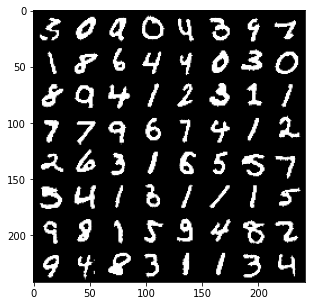

tensor([3, 0, 9, 0, 4, 3, 9, 7, 1, 8, 6, 4, 4, 0, 3, 0, 8, 9, 4, 1, 2, 3, 1, 1,
        7, 7, 9, 6, 7, 4, 1, 2, 2, 6, 3, 1, 6, 5, 5, 7, 5, 4, 1, 6, 1, 1, 1, 5,
        9, 8, 1, 5, 9, 4, 8, 2, 9, 4, 8, 3, 1, 1, 3, 4], device='cuda:0')


In [134]:
i, t = next(iter(sup_train_loader))
z_params = model.encode(i.to(device), to_categorical(t, n_classes).to(device))
z1_1, z1_2, z2 = model.reparameterize(z_params)
x1, x2 = model.decode(z1_1, z1_2, z2)

grid = make_grid(x1.view_as(fixed_batch))
plt.figure(figsize=(5, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()
print(x2.argmax(axis=1))

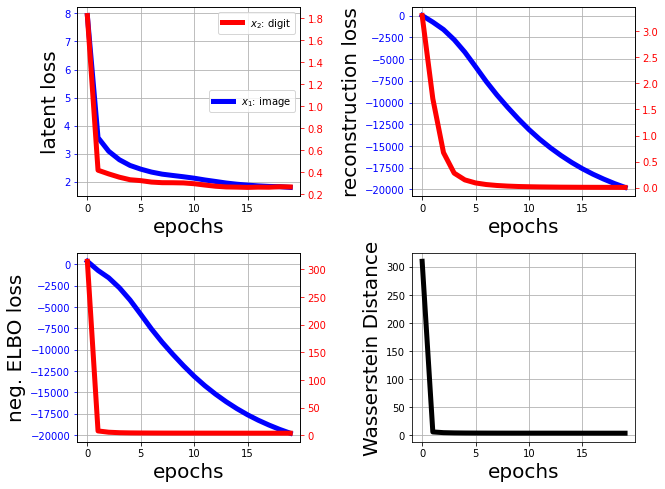

In [135]:
# Plot final loss
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221)
ax12 = ax1.twinx()
ax2 = fig.add_subplot(222)
ax22 = ax2.twinx()
ax3 = fig.add_subplot(223)
ax32 = ax3.twinx()
ax4 = fig.add_subplot(224)
fontsize=20
ax1.plot(losses_kld[:, 0].numpy(), color='b', linewidth=5, label='$x_1$: image')
ax1.tick_params(axis='y', colors='b')
ax12.plot(losses_kld[:, 1].numpy(), color='r', linewidth=5, label='$x_2$: digit')
ax12.tick_params(axis='y', colors='r')
ax2.plot(losses_kld[:, 2].numpy(), color='b', linewidth=5, label='$x_1$')
ax2.tick_params(axis='y', colors='b')
ax22.plot(losses_kld[:, 3].numpy(), color='r', linewidth=5, label='$x_2$')
ax22.tick_params(axis='y', colors='r')
ax3.plot(losses_kld[:, 4].numpy(), color='b', linewidth=5, label='$x_1$')
ax3.tick_params(axis='y', colors='b')
ax32.plot(losses_kld[:, 5].numpy(), color='r', linewidth=5, label='$x_2$')
ax32.tick_params(axis='y', colors='r')
ax4.plot(losses_kld[:, 6].numpy(), color='k', linewidth=5)
ax1.set_xlabel('epochs', fontsize=fontsize)
ax2.set_xlabel('epochs', fontsize=fontsize)
ax3.set_xlabel('epochs', fontsize=fontsize)
ax4.set_xlabel('epochs', fontsize=fontsize)
ax1.set_ylabel(r'latent loss', fontsize=fontsize)
ax2.set_ylabel(r'reconstruction loss', fontsize=fontsize)
ax3.set_ylabel(r'neg. ELBO loss', fontsize=fontsize)
ax4.set_ylabel(r'Wasserstein Distance', fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=fontsize-10)
ax1.yaxis.set_tick_params(labelsize=fontsize-10)
ax2.yaxis.set_tick_params(labelsize=fontsize-10)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc=5)
ax12.legend()
plt.subplots_adjust(wspace=0.5, hspace=0.3)

In [161]:
z11_all = torch.zeros(n_classes, n_latent).to(device)
z12_all = torch.zeros(n_classes, n_latent).to(device)
n = torch.zeros(n_classes,).to(device)
for i, t in sup_train_dataset:
    z_params = model.encode(i.unsqueeze_(0).to(device), to_categorical(t, n_classes).unsqueeze_(0).to(device))
    z1_1, z1_2, _ = model.reparameterize(z_params)
    if n[t] == 0:
        z11_all[t] += z1_1.squeeze_(0)
        z12_all[t] += z1_2.squeeze_(0)
        n[t] += 1
    if sum(n) == n_classes:
        break

for i in range(t):
    z11_all[i] /= n[i]
    z12_all[i] /= n[i]

tensor([8, 0, 1, 7, 0, 5, 9, 3, 2, 4, 4, 9, 4, 6, 6, 0, 4, 3, 1, 3, 7, 6, 6, 9,
        6, 5, 5, 5, 9, 6, 5, 7, 1, 2, 5, 8, 8, 5, 5, 1, 3, 1, 0, 9, 6, 2, 6, 7,
        8, 8, 6, 2, 0, 5, 3, 4, 9, 1, 9, 8, 9, 5, 7, 5], device='cuda:0')
tensor([8, 0, 1, 7, 0, 5, 9, 3, 2, 4, 4, 9, 4, 6, 6, 0, 4, 3, 1, 3, 7, 6, 6, 9,
        6, 5, 5, 5, 9, 6, 5, 7, 1, 2, 5, 8, 8, 5, 5, 1, 3, 1, 0, 9, 6, 2, 6, 7,
        8, 8, 6, 2, 0, 5, 3, 4, 9, 1, 9, 8, 9, 5, 7, 5])
tensor([2, 2, 2, 9, 0, 7, 9, 3, 8, 3, 5, 3, 6, 7, 1, 1, 7, 0, 5, 3, 5, 0, 8, 5,
        6, 2, 3, 3, 3, 0, 7, 0, 9, 5, 4, 1, 7, 5, 9, 0, 2, 3, 9, 6, 5, 1, 6, 0,
        6, 3, 8, 2, 0, 0, 3, 3, 7, 4, 2, 2, 5, 0, 1, 8], device='cuda:0')
tensor([4, 6, 2, 1, 0, 7, 9, 7, 9, 3, 3, 3, 5, 7, 3, 1, 8, 0, 6, 3, 5, 0, 8, 6,
        6, 6, 3, 3, 3, 0, 7, 2, 7, 5, 1, 1, 7, 5, 9, 0, 8, 3, 4, 6, 3, 4, 0, 8,
        8, 3, 9, 5, 0, 8, 0, 3, 7, 4, 3, 6, 4, 0, 8, 0])
tensor([4, 8, 6, 1, 0, 3, 7, 0, 0, 0, 7, 3, 3, 3, 6, 9, 3, 2, 3, 3, 7, 6, 0, 0,
        9, 7, 8, 2

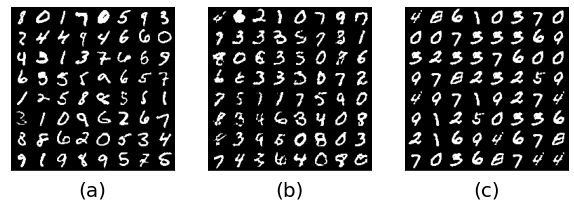

In [170]:
import random
fig = plt.figure(figsize=(10, 3))

i, t = next(iter(sup_train_loader))
z_params = model.encode(i.to(device), to_categorical(t, n_classes).to(device))
z1_1, z1_2, z2 = model.reparameterize(z_params)
x1, x2 = model.decode(z1_1, z1_2, z2)

grid = make_grid(x1.view_as(fixed_batch))
ax1 = fig.add_subplot(131)
ax1.imshow(grid.permute(1, 2, 0).cpu().numpy())
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('(a)', y=-0.2, fontsize=fontsize)
print(x2.argmax(axis=1))
print(t)

i, t = next(iter(sup_train_loader))
z_params = model.encode(i.to(device), None)
z1_1, z1_2, z2 = model.reparameterize(z_params)
x1, x2 = model.decode(z1_1, z12_all[t], z1_2)

grid = make_grid(x1.view_as(fixed_batch))
ax1 = fig.add_subplot(132)
ax1.imshow(grid.permute(1, 2, 0).cpu().numpy())
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('(b)', y=-0.2, fontsize=fontsize)
print(x2.argmax(axis=1))
print(t)

i, t = next(iter(sup_train_loader))
z_params = model.encode(i.to(device), to_categorical(t, n_classes).to(device))
z1_1, z1_2, z2 = model.reparameterize(z_params)
x1, x2 = model.decode(z11_all[t], z2, z2)

grid = make_grid(x1.view_as(fixed_batch))
ax1 = fig.add_subplot(133)
ax1.imshow(grid.permute(1, 2, 0).cpu().numpy())
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('(c)', y=-0.2, fontsize=fontsize)
print(x2.argmax(axis=1))
print(t)

plt.show()